In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/fyp_prototype/stylegan.zip -d /content/
real_path = "/content/rvf10k/train/real"
fake_path = "/content/rvf10k/train/fake"

Streaming output truncated to the last 5000 lines.
  inflating: /content/rvf10k/train/real/28056.jpg  
  inflating: /content/rvf10k/train/real/28081.jpg  
  inflating: /content/rvf10k/train/real/28160.jpg  
  inflating: /content/rvf10k/train/real/28181.jpg  
  inflating: /content/rvf10k/train/real/28190.jpg  
  inflating: /content/rvf10k/train/real/28192.jpg  
  inflating: /content/rvf10k/train/real/28194.jpg  
  inflating: /content/rvf10k/train/real/28197.jpg  
  inflating: /content/rvf10k/train/real/28199.jpg  
  inflating: /content/rvf10k/train/real/28247.jpg  
  inflating: /content/rvf10k/train/real/28281.jpg  
  inflating: /content/rvf10k/train/real/28308.jpg  
  inflating: /content/rvf10k/train/real/28316.jpg  
  inflating: /content/rvf10k/train/real/28332.jpg  
  inflating: /content/rvf10k/train/real/28342.jpg  
  inflating: /content/rvf10k/train/real/28345.jpg  
  inflating: /content/rvf10k/train/real/28347.jpg  
  inflating: /content/rvf10k/train/real/28392.jpg  
  inflating: 

Training HybridVAE on local dataset...
Epoch 1: Total Loss = 132.3389, Recon = 130.7565, KL = 0.0081, Class = 0.6930, Triplet = 0.0079
Epoch 2: Total Loss = 123.5502, Recon = 122.6154, KL = 0.0016, Class = 0.6932, Triplet = 0.0079
Epoch 3: Total Loss = 120.7637, Recon = 119.8182, KL = 0.0017, Class = 0.6932, Triplet = 0.0079
Epoch 4: Total Loss = 120.2332, Recon = 119.3022, KL = 0.0016, Class = 0.6932, Triplet = 0.0079
Epoch 5: Total Loss = 120.0774, Recon = 119.1802, KL = 0.0013, Class = 0.6931, Triplet = 0.0079
Epoch 6: Total Loss = 119.9445, Recon = 119.0513, KL = 0.0012, Class = 0.6931, Triplet = 0.0079
Epoch 7: Total Loss = 119.6268, Recon = 118.7345, KL = 0.0012, Class = 0.6931, Triplet = 0.0079
Epoch 8: Total Loss = 119.6845, Recon = 118.8212, KL = 0.0009, Class = 0.6932, Triplet = 0.0079
Epoch 9: Total Loss = 119.5105, Recon = 118.6536, KL = 0.0009, Class = 0.6931, Triplet = 0.0079
Epoch 10: Total Loss = 119.3719, Recon = 118.5111, KL = 0.0009, Class = 0.6930, Triplet = 0.0079


<ipython-input-2-aa3afc41d9ee>:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("hybrid_model.pth", map_location=device))


Sample predictions (0: real, 1: fake): [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0]


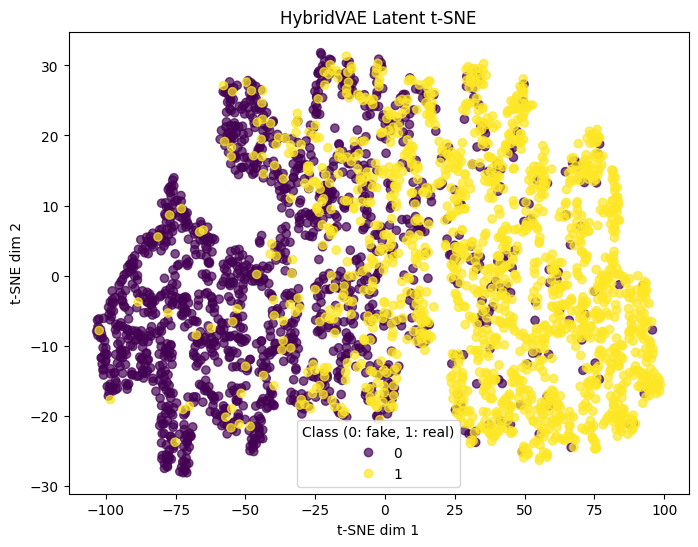

In [2]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from PIL import Image


# 1. DataLoader Setup Using a Local Dataset


#  IMAGE_SIZE is 128 and BATCH_SIZE is 128.
DATA_DIR = '/content/rvf10k'
IMAGE_SIZE = 128
BATCH_SIZE = 128

common_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=common_transform)
valid_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'valid'), transform=common_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Hybrid Model: Disentangled VAE with a Classification Head

LATENT_DIM = 24

class HybridVAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_classes=2):
        super(HybridVAE, self).__init__()
        # Encoder:
        # Input image: 3 x 128 x 128
        self.encoder = nn.Sequential(
            # Conv1: 128x128 -> 64x64
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Conv2: 64x64 -> 32x32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Conv3: 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Conv4: 16x16 -> 8x8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        # The flattened feature map size is 256 * 8 * 8 = 16384.
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder:
        # Map latent vector back to a feature map of size (256, 8, 8)
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            # Deconv1: 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Deconv2: 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Deconv3: 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Deconv4: 64x64 -> 128x128
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # outputs in [-1, 1]
        )
        # Classifier head based on the latent mean (mu)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the feature maps
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        # Reshape into feature maps of shape (batch, 256, 8, 8)
        h = h.view(h.size(0), 256, 8, 8)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        logits = self.classifier(mu)
        return x_recon, mu, logvar, logits

# 3. Triplet Loss for Increasing Latent Separability

def compute_triplet_loss(embeddings, labels, margin=1.0):
    """
    Computes a simple triplet loss over the batch.
    For each anchor, randomly selects a positive (same class) and a negative (different class).
    """
    triplet_loss = 0.0
    num_triplets = 0
    batch_size = embeddings.shape[0]
    for i in range(batch_size):
        anchor = embeddings[i]  # shape: (latent_dim,)
        pos_indices = (labels == labels[i]).nonzero(as_tuple=False).squeeze()
        neg_indices = (labels != labels[i]).nonzero(as_tuple=False).squeeze()
        if pos_indices.dim() == 0:
            pos_indices = pos_indices.unsqueeze(0)
        pos_indices = pos_indices[pos_indices != i]
        if pos_indices.numel() == 0 or neg_indices.numel() == 0:
            continue
        pos_idx = pos_indices[torch.randint(0, pos_indices.numel(), (1,))]
        neg_idx = neg_indices[torch.randint(0, neg_indices.numel(), (1,))]
        positive = embeddings[pos_idx]
        negative = embeddings[neg_idx]
        loss_val = F.triplet_margin_loss(anchor.unsqueeze(0), positive, negative, margin=margin, p=2)
        triplet_loss += loss_val
        num_triplets += 1
    if num_triplets > 0:
        triplet_loss = triplet_loss / num_triplets
    return triplet_loss

# 4. Loss Function for the Hybrid Approach (with Triplet Loss)


def hybrid_loss(x, x_recon, mu, logvar, logits, labels,
                beta=100.0, lambda_recon=0.01, lambda_class=1.0, lambda_triplet=10.0, margin=1.0):
    recon_loss = lambda_recon * F.mse_loss(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = F.cross_entropy(logits, labels, reduction='sum')
    triplet_loss = compute_triplet_loss(mu, labels, margin=margin)
    total_loss = recon_loss + beta * kl_loss + lambda_class * class_loss + lambda_triplet * triplet_loss
    return total_loss, recon_loss, kl_loss, class_loss, triplet_loss

# 5. Training Loop for the Hybrid Model

def train_hybrid(model, data_loader, epochs=50, lr=1e-3,
                 beta=100.0, lambda_recon=0.01, lambda_class=1.0, lambda_triplet=10.0, margin=1.0):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_recon = 0.0
        running_kl = 0.0
        running_class = 0.0
        running_triplet = 0.0
        for data, labels in data_loader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar, logits = model(data)
            loss, recon_loss, kl_loss, class_loss, triplet_loss = hybrid_loss(
                data, x_recon, mu, logvar, logits, labels,
                beta=beta, lambda_recon=lambda_recon, lambda_class=lambda_class,
                lambda_triplet=lambda_triplet, margin=margin)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_recon += recon_loss.item()
            running_kl += kl_loss.item()
            running_class += class_loss.item()
            running_triplet += triplet_loss.item()
        n = len(data_loader.dataset)
        print(f"Epoch {epoch+1}: Total Loss = {running_loss/n:.4f}, Recon = {running_recon/n:.4f}, KL = {running_kl/n:.4f}, Class = {running_class/n:.4f}, Triplet = {running_triplet/n:.4f}")
    return model

# 6. Latent Feature Extraction and t‑SNE Visualization

def extract_latents_hybrid(model, data_loader):
    model.eval()
    latents = []
    labels_list = []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            labels_list.extend(labels.numpy())
    latents = np.concatenate(latents, axis=0)
    return latents, np.array(labels_list)

def visualize_tsne(latents, labels, title="t‑SNE Visualization"):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    latents_2d = tsne.fit_transform(latents)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Class (0: fake, 1: real)")
    plt.title(title)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.show()

# 7. Main Routine: Train, Save, Load, and Test Hybrid Model

if __name__ == '__main__':
    num_epochs = 50  # Adjust as needed

    print("Training HybridVAE on local dataset...")
    hybrid_model = HybridVAE(latent_dim=LATENT_DIM, num_classes=2)
    hybrid_model = train_hybrid(hybrid_model, train_loader, epochs=num_epochs, lr=1e-3,
                                beta=100.0, lambda_recon=0.01, lambda_class=1.0, lambda_triplet=10.0, margin=1.0)

    # Save the model's state dictionary after training
    torch.save(hybrid_model.state_dict(), "hybrid_model.pth")
    print("Model saved successfully as 'hybrid_model.pth'.")

    # Reload the model
    loaded_model = HybridVAE(latent_dim=LATENT_DIM, num_classes=2)
    loaded_model.load_state_dict(torch.load("hybrid_model.pth", map_location=device))
    loaded_model.to(device)
    loaded_model.eval()
    print("Loaded model and set to evaluation mode.")

    # Test the loaded model on validation set (optional)
    sample_data, sample_labels = next(iter(valid_loader))
    sample_data = sample_data.to(device)
    with torch.no_grad():
        x_recon, mu, logvar, logits = loaded_model(sample_data)
    predictions = torch.argmax(logits, dim=1)
    print("Sample predictions (0: real, 1: fake):", predictions.cpu().numpy())

    # Visualize latent space using t‑SNE (optional)
    latents_hybrid, labels_hybrid = extract_latents_hybrid(loaded_model, valid_loader)
    visualize_tsne(latents_hybrid, labels_hybrid, title="HybridVAE Latent t‑SNE")


In [3]:
# Evaluate model accuracy on validation set
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            labels = labels.to(device)
            _, _, _, logits = model(data)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

accuracy = evaluate_model(loaded_model, valid_loader)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# ---------------------------
# Upload an image and use the loaded model for prediction
# ---------------------------
from google.colab import files
from PIL import Image

# Upload image file
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")
    # Open the image and apply preprocessing
    image = Image.open(filename).convert("RGB")
    image_tensor = common_transform(image).unsqueeze(0).to(device)  # add batch dimension

    # Use the loaded model to predict the class
    with torch.no_grad():
        _, _, _, logits = loaded_model(image_tensor)
    prediction = torch.argmax(logits, dim=1).item()
    print(f"Prediction for {filename}: {prediction} (0: fake, 1: real)")


Validation Accuracy: 82.47%


In [4]:
print(train_dataset.class_to_idx)


{'fake': 0, 'real': 1}


In [7]:
import unittest
import torch


class TestHybridVAE(unittest.TestCase):
    def setUp(self):
        self.model = HybridVAE()  # No need to import here, it's defined above
        self.sample_input = torch.randn(1, 3, 128, 128)

    def test_forward_pass(self):
        x_recon, mu, logvar, logits = self.model(self.sample_input)
        self.assertEqual(logits.shape, (1, 2))  # Check if the output has 2 classes

# Execute the tests
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.037s

OK


In [10]:
import time
image_tensor = torch.randn(1, 3, 128, 128).to(device)
start_time = time.time()

x_recon, mu, logvar, logits = loaded_model(image_tensor)
end_time = time.time()
print(f"Inference Time: {end_time - start_time} seconds")

Inference Time: 0.09533286094665527 seconds


In [15]:
batch_input = torch.randn(32, 3, 128, 128).to(device)
x_recon, mu, logvar, logits = loaded_model(batch_input)
print(f"Processed batch of {batch_input.shape[0]} images")

Processed batch of 32 images


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = np.array([1, 0, 1, 1, 0])
y_pred = np.array([1, 0, 1, 0, 0])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [21]:
corrupt_image = torch.zeros(1, 3, 128, 128).to(device)  # Black image with no content
x_recon, mu, logvar, logits = loaded_model(corrupt_image)